# This notebook load pretrained CNN models for cloud detection in RGB images
It has been developed by the team of the work package NUAGES of the mission CubeSat ESUS of CentraleSupélec (Paris-Saclay). 

Its aim is to detect the total amount of clouds in images taken by the satellite's camera and then to label each one according to a certain threshold.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time

**Load model**

In [2]:
# Definition of the class for UNET models 
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand


In [3]:
# Definition of the class for UNET-LITE models (lighter because of less convolutional layers)
from torch import nn
class UNETLITE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        #self.conv3 = self.contract_block(64, 128, 3, 1)

        #self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64, 32, 3, 1)
        #self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        #conv3 = self.conv3(conv2)

        #upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(conv2)
        #upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            #torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            #torch.nn.BatchNorm2d(out_channels),
            #torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            #torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            #torch.nn.BatchNorm2d(out_channels),
                            #torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [4]:
# Model by state dictionary
model = UNET(3,2)
model.load_state_dict(torch.load('../input/unetsparcs/unet_state_dict_sparcs',map_location='cpu'))
model.eval()

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [5]:
# Model by script
model2 = UNET(3,2)
model2 = torch.load('../input/unetsparcs/unet_model_sparcs',map_location='cpu')
model2.eval()

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [6]:
# Model by state dictionary
model_lite1 = UNETLITE(3,2)
model_lite1.load_state_dict(torch.load('../input/l8-model/unet_state_dict_L8_lite',map_location='cpu'))
model_lite1.eval()

UNETLITE(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (upconv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (upconv1): Sequential(
    (0): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [7]:
# Model by script
model_lite2 = UNETLITE(3,2)
model_lite2 = torch.load('../input/l8-model/unet_model_L8_lite',map_location='cpu')
model_lite2.eval()

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (upconv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (upconv1): Sequential(
    (0): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

**Prepare images** from training set

In [8]:
# Define the dataset class
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
       # if include_nir:
        #    nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
         #   raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [9]:
#Assign the correct input path
base_path = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [10]:
# Define function for result visualization
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

def plot_response(predb_to_mask, idx):
 A=np.nonzero(predb_to_mask(predb,idx))
 pred_array=[len(A)/(384*384), 1-(len(A)/(384*384))]
 label=['Nuage','Clair']
 plt.grid(False)
 plt.xticks(range(2))
 plt.yticks([])
 thisplot = plt.bar(range(2), pred_array, color="#777777")
 plt.ylim([0, 1])
 predicted_label = np.argmax(pred_array)
 thisplot[0].set_color('red')
 thisplot[1].set_color('blue')
 plt.xlabel("{} {:2.0f}%".format(label[predicted_label],100*np.max(pred_array)))

In [11]:
# Load random data in a batch
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)

In [12]:
# Sort random data from the training dataset
xb,yb= next(iter(train_dl))
xb.shape

torch.Size([12, 3, 384, 384])

In [13]:
# Make the prediction
with torch.no_grad():
    predb = model_lite1(xb)

predb.shape

torch.Size([12, 2, 384, 384])

**Result**

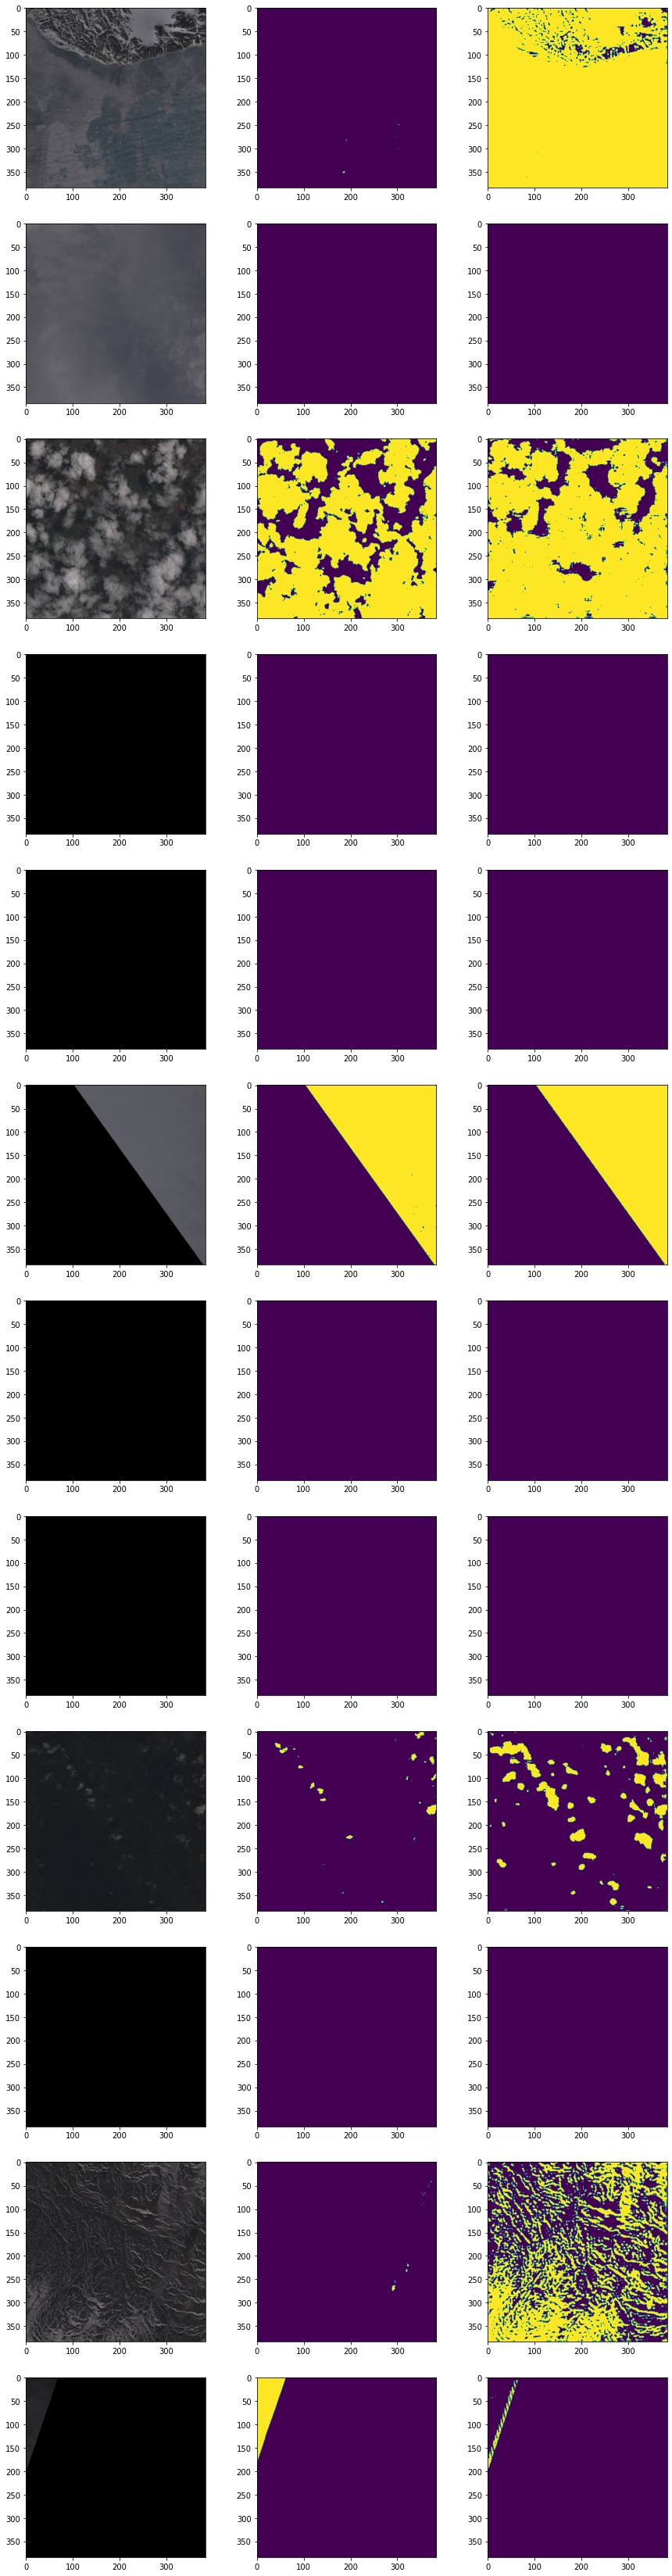

In [14]:
#Visualize resultant images
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

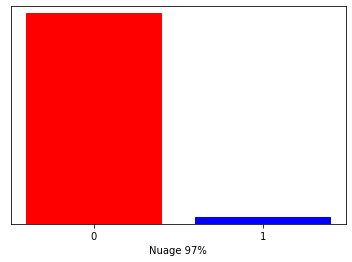

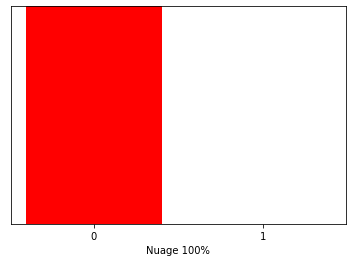

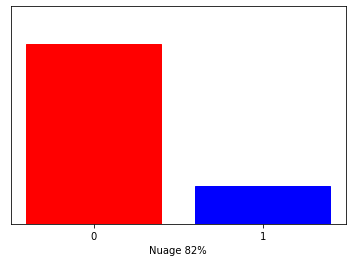

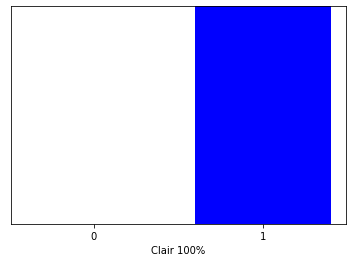

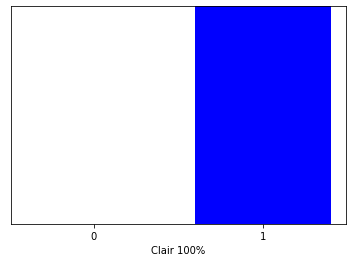

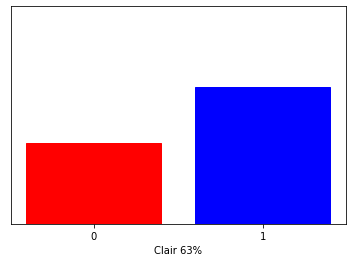

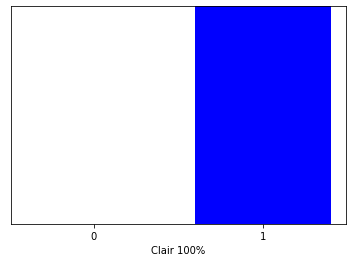

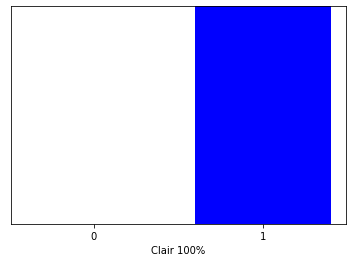

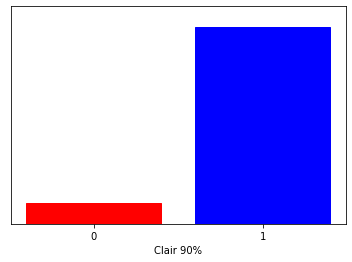

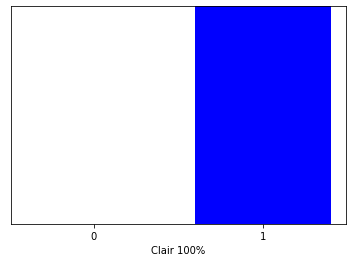

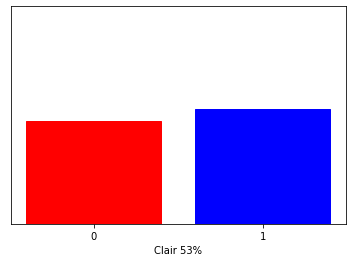

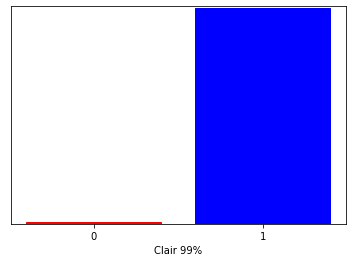

In [15]:
#Visualize threshold evaluation
bs = 12
for i in range(bs):
    plot_response(predb_to_mask, i)
    plt.show()

**Prepare images** from test set

In [16]:
# Inizialization of the dataset
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        #if include_nir:
         #   nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
          #  raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        
        return x
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s
    
    

In [17]:
# Assign the right input path
base_path = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_test')
data2 = CloudDataset(base_path/'test_red', 
                    base_path/'test_green', 
                    base_path/'test_blue', 
                    base_path/'test_nir')
data2

Dataset class with 9201 files

In [18]:
# Define function for result visualization
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

def plot_response(predb_to_mask, idx):
 A=np.nonzero(predb_to_mask(predb,idx))
 pred_array=[len(A)/(384*384), 1-(len(A)/(384*384))]
 label=['Nuage','Clair']
 plt.grid(False)
 plt.xticks(range(2))
 plt.yticks([])
 thisplot = plt.bar(range(2), pred_array, color="#777777")
 plt.ylim([0, 1])
 predicted_label = np.argmax(pred_array)
 thisplot[0].set_color('red')
 thisplot[1].set_color('blue')
 plt.xlabel("{} {:2.0f}%".format(label[predicted_label],100*np.max(pred_array)))

In [19]:
# Load random data in a batch
train_ds, valid_ds = torch.utils.data.random_split(data2, (6000, 3201))
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)

In [20]:
# Sort random data from training dataset
xb= next(iter(train_dl))
xb.shape

torch.Size([12, 3, 384, 384])

In [21]:
#Make predictions
with torch.no_grad():
    predb = model_lite1(xb)

predb.shape

torch.Size([12, 2, 384, 384])

**Result**

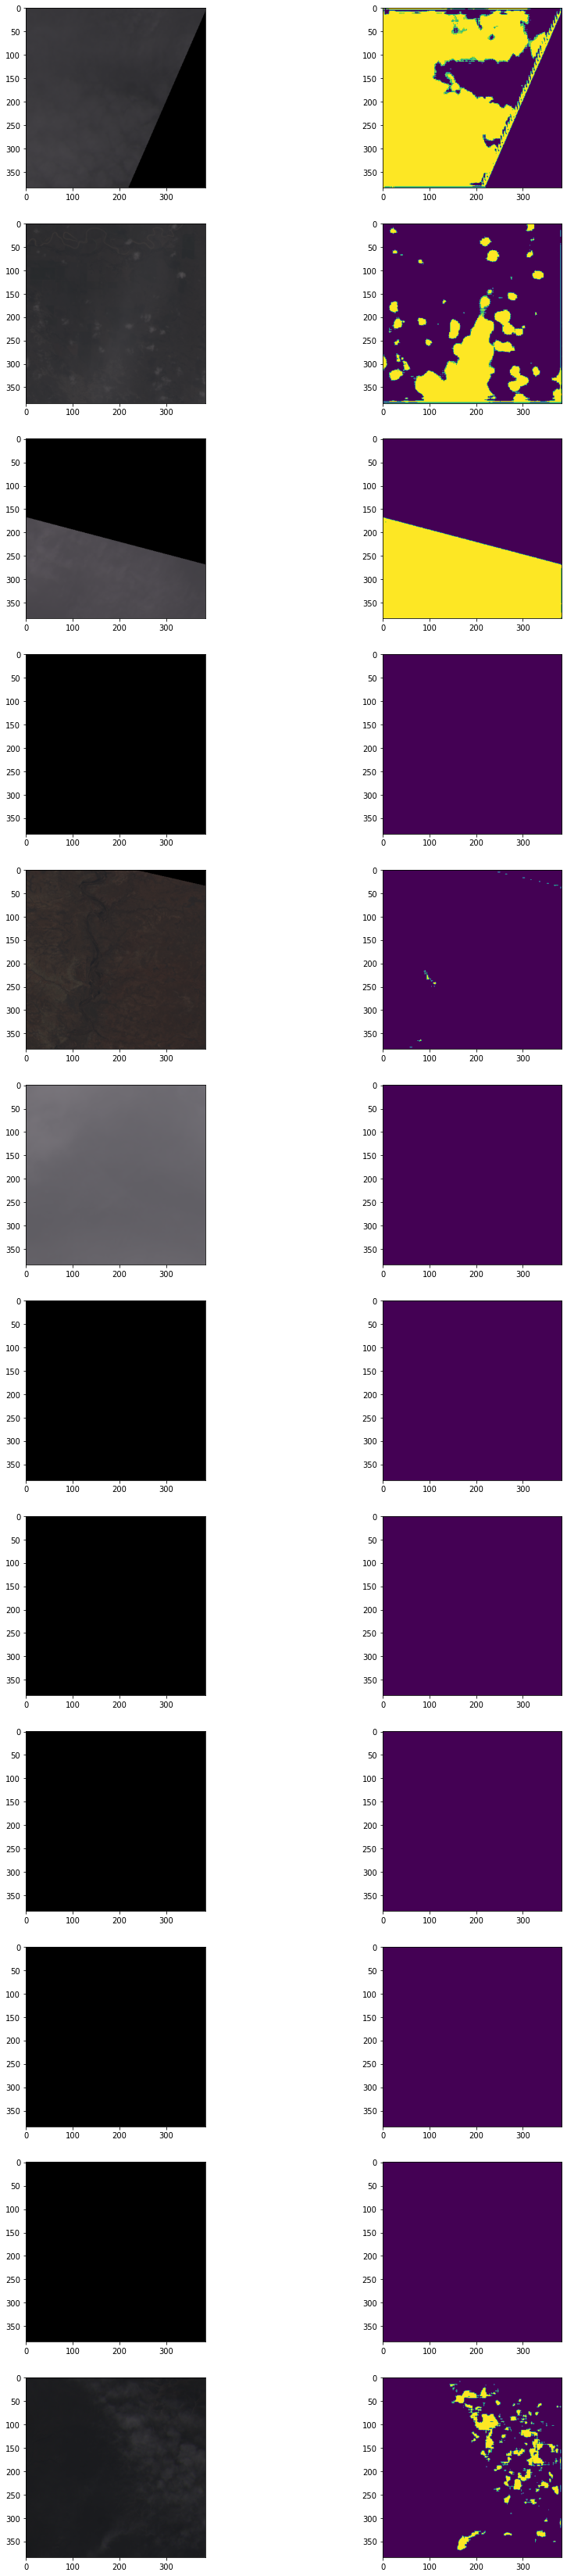

In [22]:
#Visualize resultant images
bs = 12
fig, ax = plt.subplots(bs,2, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(predb_to_mask(predb, i))

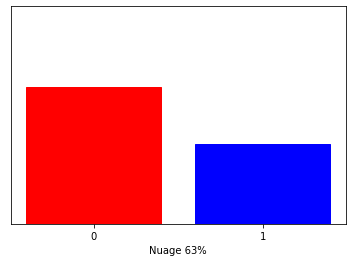

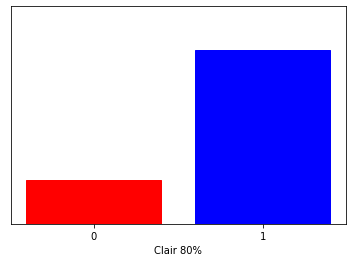

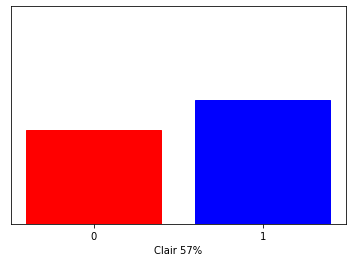

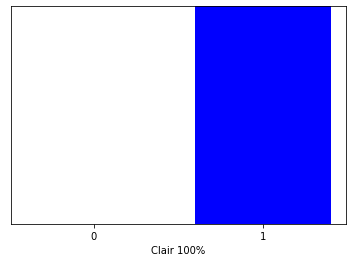

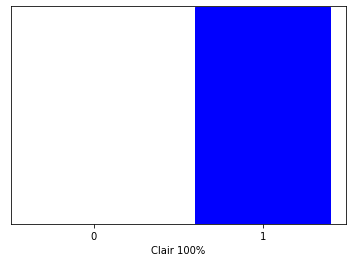

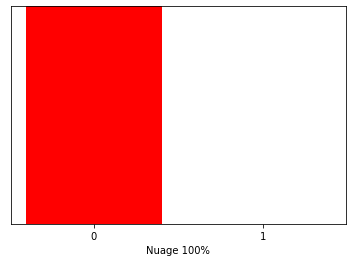

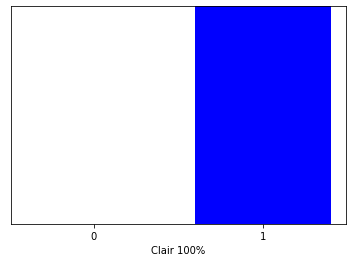

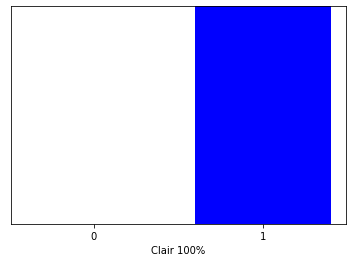

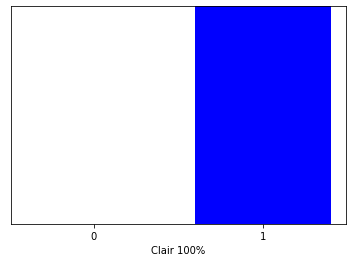

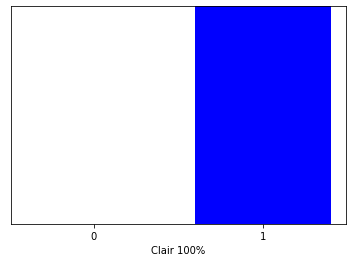

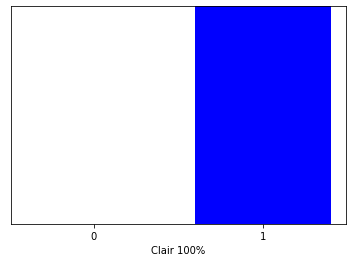

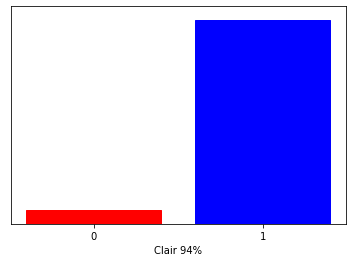

In [23]:
# Visualize threshold evaluation
bs = 12
for i in range(bs):
    plot_response(predb_to_mask, i)
    plt.show()

# Load RGB image 

In [24]:
import torchvision.transforms.functional as fn

In [25]:
# Initialization of the dataset
class SparcsDataset(Dataset):
    def __init__(self, img_dir):
        super().__init__()
    
        self.files = [f for f in img_dir.iterdir() if not f.is_dir()]
                                      
    def __len__(self):
        
        return len(self.files)
     
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        img=Image.open(self.files[idx])
        img_rsz = fn.resize(img, size=[384,384])
        imgarr = np.array(img_rsz, dtype=np.float32)
        raw_rgb = imgarr.transpose((2,0,1))
        
        # normalize
        return (raw_rgb /256) #np.finfo(raw_rgb.dtype).max)
    
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx), dtype=torch.float32)
        
        return x
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [26]:
#Assign right input path for RGB images 
base_path = Path('../input/sparcs-png')
dataRGB=SparcsDataset(base_path)
dataRGB

Dataset class with 80 files

In [27]:
# Define functions for visualization of the result
def batch_to_img(xc, idx):
    img = np.array(xc[idx,0:3])
    return img.transpose((1,2,0))

def predc_to_mask(predc, idx):
    p = torch.functional.F.softmax(predc[idx], 0)
    return p.argmax(0).cpu()

def plot_response(predc_to_mask, idx):
 A=np.nonzero(predc_to_mask(predc,idx))
 pred_array=[len(A)/(384*384), 1-(len(A)/(384*384))]
 label=['Nuage','Clair']
 plt.grid(False)
 plt.xticks(range(2))
 plt.yticks([])
 thisplot = plt.bar(range(2), pred_array, color="#777777")
 plt.ylim([0, 1])
 predicted_label = np.argmax(pred_array)
 thisplot[0].set_color('red')
 thisplot[1].set_color('blue')
 plt.xlabel("{} {:2.0f}%".format(label[predicted_label],100*np.max(pred_array)))

In [28]:
# Load random data from the dataset
test_RGB = DataLoader(dataRGB, batch_size=6, shuffle=True)

In [29]:
# Sort data from testing dataset
xc= next(iter(test_RGB))
xc.shape

torch.Size([6, 3, 384, 384])

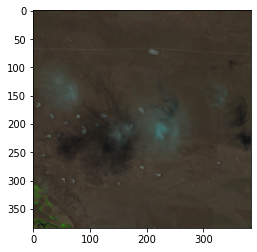

In [30]:
#Visualize random input image
img = np.array(xc[1,0:3])
img=img.transpose((1,2,0))
plt.imshow(img)

In [31]:
# Make prediction
with torch.no_grad():
    predc = model_lite1(xc)

predc.shape

torch.Size([6, 2, 384, 384])

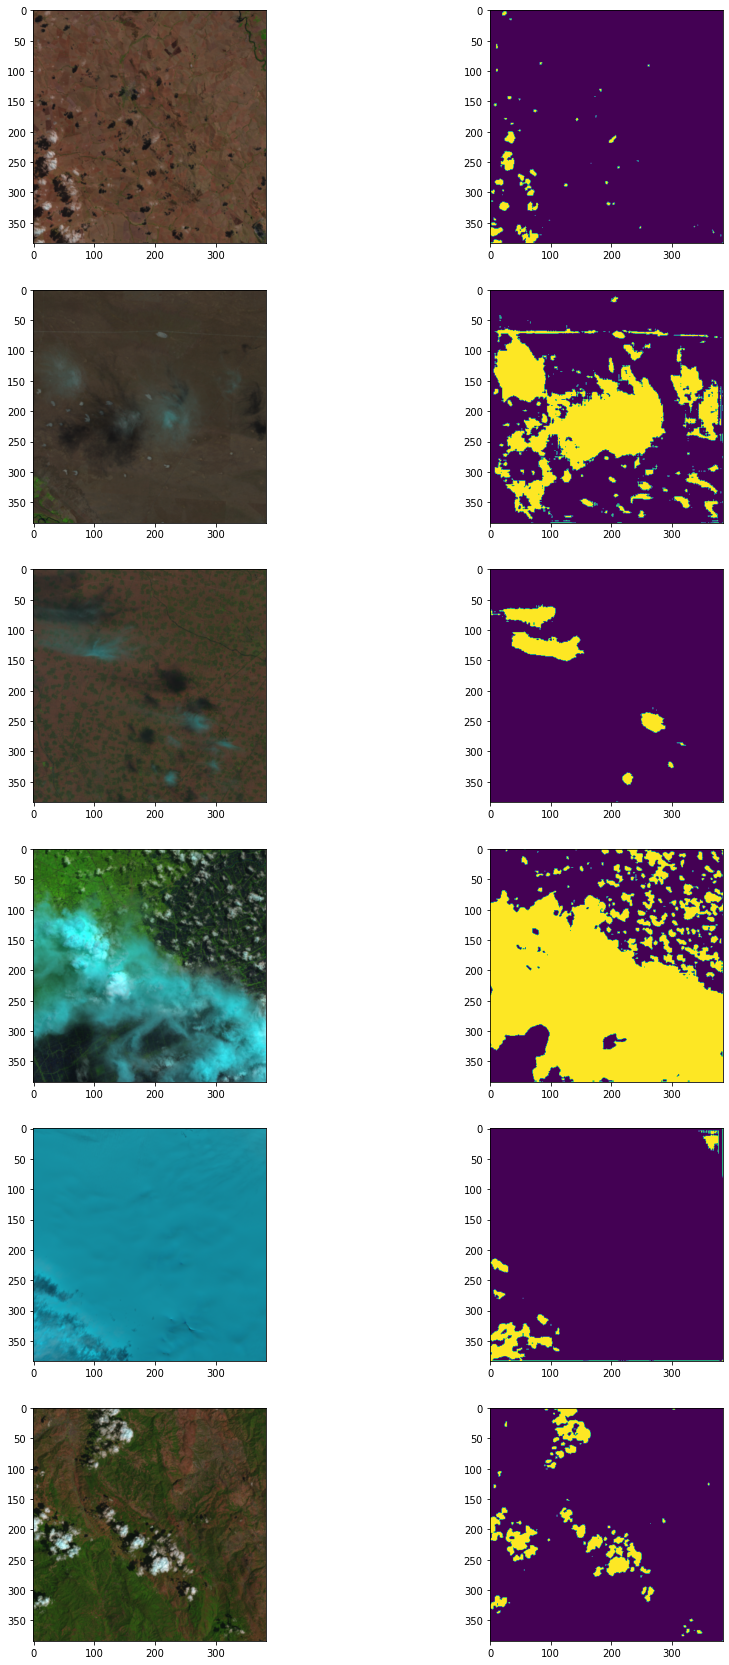

In [32]:
# Visualize resultant images
bs = 6
fig, ax = plt.subplots(bs,2, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xc,i))
    ax[i,1].imshow(predc_to_mask(predc, i))

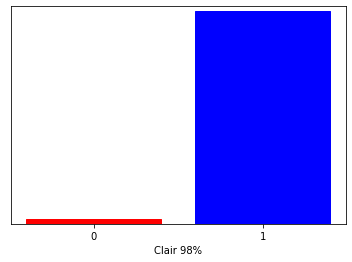

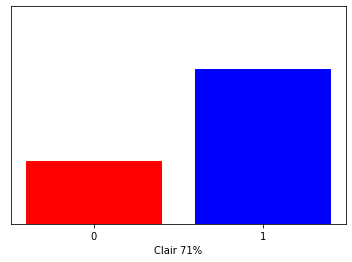

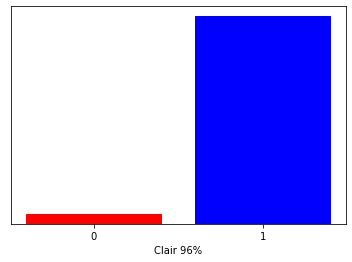

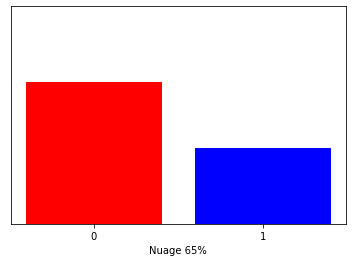

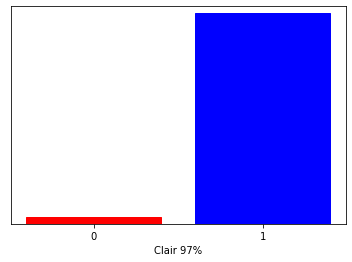

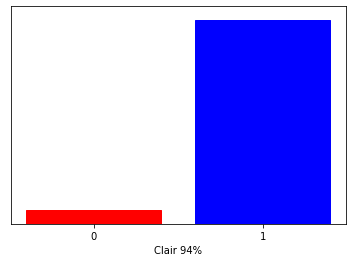

In [33]:
#Visulize threshold result
bs = 6
for i in range(bs):
    plot_response(predc_to_mask, i)
    plt.show()